In [4]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv


## Prequisite
Non stationarity means with statistical properties, like mean, variance, and autocorrelation change over time.
<br>Types of Non-Stationarity
1. **Deterministic Trends**: Trend that can me modeled with deterministic function, ex: linear or polynomial trend.
2. **Stochastic Trends**: Trend that follow a random walk or a unit root process, where the series has a presistent, random component that causes the series to drift over time,
3. **Seasonal Non-Stationarity**: Regular patterns or cycles that repeat over a fixed period, such as monthly sales data showing seasonal effects.

## Identifying Non-Stationarity
1. Visual.
2. ADF(Statistical): Test the presence of unit root.
3. Kwiatkowski-Phillips-Schmidt-Shin (KPSS)(Statistical): test against the alternative of a unit root.
4. Phillips-Perron (PP) test: testing uni roots.

## Stationarization
This is more like a follow up from my Dickey-Fuller Test what is used to check if a time series data is stationary. <br>
After we check the time series data, if its found to be non-stationary then we can turn it into stationary using these process. <br>

- Financial institution and corporations, as well as individual investor and researcher usually use time series data like exchange rates, GDP, inflation, and other macroeconomic indicator in economic forecast, stock market analysis.

## Dataset
The dataset that i am using is the Tesla stock dataset because after checking it using the dickey-fuller test, I found out that it was not stationary.

## Loading The Dataset

In [5]:
df = pd.read_csv('/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv')

In [6]:
# For this test we'll only be using the Date and Close Columns for simplicity
df = df[['Date', 'Close']]

In [7]:
df.index = df['Date']
del df['Date']

In [8]:
df.head()

,Close
Date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


In [9]:
#I think i need to trim this data
df = df.head(500)

## 1. Differencing
- Subtracting the previous observation from the current observation. This is known as first differenceing. Higher order differencing can be used if necessary.

In [10]:
df['diff'] = df['Close'].diff()

## 2. Log Transformation
- Applying the logarithm can stabilize the variance and make the series more stationary.

In [11]:
df['log_value'] = np.log(df['Close'])

## 3. Detrending
- Removing a deterministic trend by fitting a model (e.g., linear regression) and subtracting the fitted values from the original series.

In [12]:
from scipy import stats
df['detrended'] = df['Close'] - stats.linregress(range(len(df)), df['Close'])[0] * range(len(df))

## 4. Seasonal Adjustment
- Removing seasonal effects by subtracting the seasonal component. This can be done using methods like Seasonal and Trend decomposition using Loess (STL).

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='additive', period=12)
df['seasonal_adjusted'] = df['Close'] - result.seasonal

## Plotting

In [14]:
import matplotlib.pyplot as plt

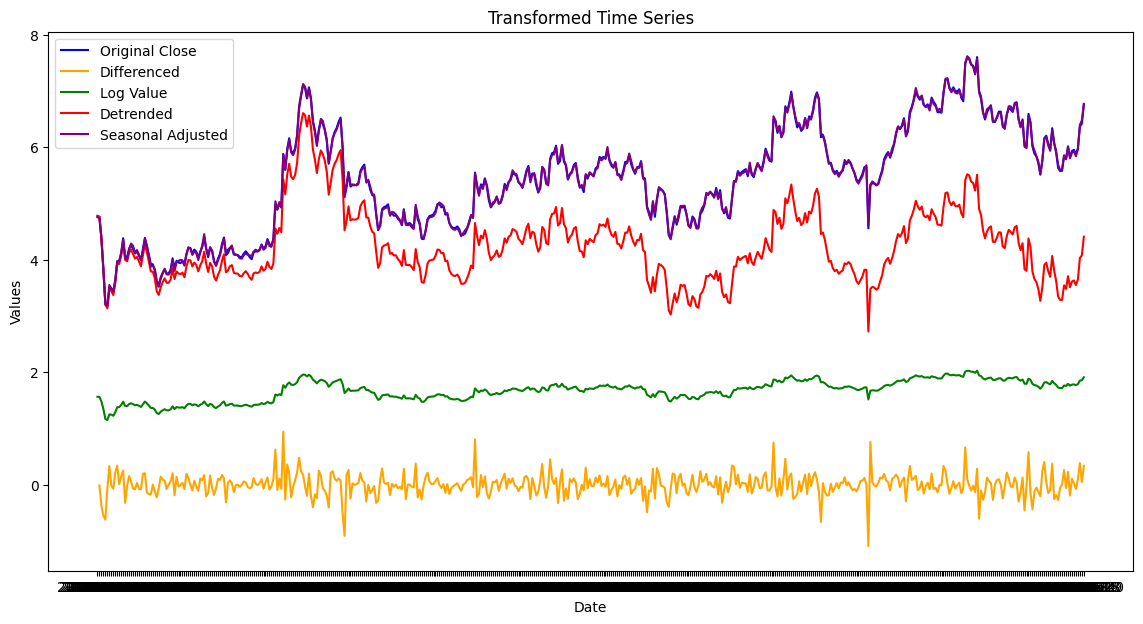

In [15]:
plt.figure(figsize=(14, 7))

plt.plot(df.index, df['Close'], label='Original Close', color='blue')
plt.plot(df.index, df['diff'], label='Differenced', color='orange')
plt.plot(df.index, df['log_value'], label='Log Value', color='green')
plt.plot(df.index, df['detrended'], label='Detrended', color='red')
plt.plot(df.index, df['seasonal_adjusted'], label='Seasonal Adjusted', color='purple')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Transformed Time Series')
plt.legend()
plt.show()

I am particullary interested in the differenced line and would like to investigate using the Dickey-Fuller Test.

In [16]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def adf_test(timeseries):
    print('Result of Augmented Dickey-Fuller Test')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')  # Drop NaNs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [20]:
adf_test(df['diff'])

Result of Augmented Dickey-Fuller Test
Test Statistic                -1.689161e+01
p-value                        1.044054e-29
#Lags Used                     1.000000e+00
Number of Observations Used    4.970000e+02
Critical Value (1%)           -3.443576e+00
Critical Value (5%)           -2.867373e+00
Critical Value (10%)          -2.569877e+00
dtype: float64


- Test statistic is much lower than the 1%, 5%, and 10% significance. This mean we can reject the null hypothesis with strong evidence. <br>
- Extremely low p-value also rejecting the null hypothesis, indicagting the time series is stationary. <br>
With this We can say the series is stationary, does not have a unit root, mean variance are constant.